In [1]:
#limpio la memoria
rm(list=ls())
gc()

#cargo librerias
library("data.table")
library("ROCR")
library("ranger")

library("caret")


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,613796,32.8,1330092,71.1,1086417,58.1
Vcells,1149477,8.8,8388608,64.0,1801053,13.8


Loading required package: ggplot2

Loading required package: lattice



In [2]:
#para poder usarlo en la PC y en la nube
switch ( Sys.info()[['sysname']],
         Windows = { directory.root   <-  "M:\\" },   #Microsoft Windows
         Darwin  = { directory.root   <-  "~/dm/" },  #Apple MAC
         Linux   = { directory.root   <-  "~/buckets/b1/" }  #Entorno Google Cloud
       )
#defino la carpeta donde trabajo
setwd( directory.root )

#Parametros entrada

#kcarpeta_datasets    <- "../input/laboratorio-de-implementacion-i-2021/"   #KAGGLE
kcarpeta_datasets    <- "./datasets/"                          #VM o Ubuntu

#Archivo con datos etiquetados para entrenamiento
karchivo_entrada      <-  paste0(kcarpeta_datasets, "competencia1_2022_FE.csv")

#Formato para submit en Kaggle
#karchivo_score      <-  "../input/uamds2020ldi1f1/Sample_201910_Fase_I.txt"

#Separador de campos en archivos
kcampos_separador     <-  "\t"

#Campo que identifica las muestras
kcampo_id             <-  "numero_de_cliente"

#Campo que contiene la clase a estimar
kclase_nomcampo       <-  "clase_ternaria"

#Valor de interés
kclase_valor_positivo <-  "BAJA+2"

#Campos a borrar para el entrenamiento
kcampos_a_borrar      <-  c(kcampo_id,kclase_nomcampo,"foto_mes")

#Campo que contendrá a la variable objetivo generada
kobjetivo             <-  "clase"

#Identificación del modelo
kmodelo               <-  "02-RPART"

#Ganancia por TP
kTPGain               <-  78000

#Pérdida por FP
kFPGain               <-  -2000

#Establezco semilla aleatoria
set.seed(1)



In [ ]:
#cargo los datos
dataset <- fread(karchivo_entrada)

#Para hacer pruebas rapidas puedo reducir el dataset a una fraccion
#subsample <- sample(1:nrow(dataset), .1 * nrow(dataset))
#dataset <- dataset[subsample,]

dtrain  <- dataset[ foto_mes==202101 ]  #defino donde voy a entrenar

train_rows <- createDataPartition(dtrain$clase, p = .66, list = FALSE)

#train_rows <- sample(1:nrow(dataset), .66 * nrow(dataset))
dtest <- dtrain[-train_rows,]
dtrain_split <- dtrain[train_rows,]

dapply  <- dataset[ foto_mes==202103 ]  #defino donde voy a aplicar el modelo

In [10]:
# generacion del modelo
formula_obj  <-  formula(paste("clase_ternaria ~ ."))

In [11]:
t0       <-  Sys.time()
modelo  <- ranger( data = dtrain_split,  
                   formula_obj,  
                   probability=TRUE,
                   num.trees= 900, 
                   min.node.size= 360, 
                   mtry= 4, 
                   splitrule='gini'
                 ) 
t1       <-  Sys.time()

tcorrida <-  as.numeric( t1 - t0, units = "secs")
print( tcorrida)

ERROR: Error: Missing data in columns: mtarjeta_visa_descuentos, mtarjeta_master_descuentos, Master_delinquency, Master_status, Master_mfinanciacion_limite, Master_Fvencimiento, Master_Finiciomora, Master_msaldototal, Master_msaldopesos, Master_msaldodolares, Master_mconsumospesos, Master_mconsumosdolares, Master_mlimitecompra, Master_madelantopesos, Master_madelantodolares, Master_fultimo_cierre, Master_mpagado, Master_mpagospesos, Master_mpagosdolares, Master_fechaalta, Master_mconsumototal, Master_cconsumos, Master_cadelantosefectivo, Master_mpagominimo, Visa_delinquency, Visa_status, Visa_mfinanciacion_limite, Visa_Fvencimiento, Visa_Finiciomora, Visa_msaldototal, Visa_msaldopesos, Visa_msaldodolares, Visa_mconsumospesos, Visa_mconsumosdolares, Visa_mlimitecompra, Visa_madelantopesos, Visa_madelantodolares, Visa_fultimo_cierre, Visa_mpagado, Visa_mpagospesos, Visa_mpagosdolares, Visa_fechaalta, Visa_mconsumototal, Visa_cconsumos, Visa_cadelantosefectivo, Visa_mpagominimo.


In [ ]:
#Evalúo sobre test
prediccion <- predict(modelo, dtest,) # predicted values

#Calculo ganancia sobre dataset de pruebas
dtest[ , prob_baja2 := prediccion[, "BAJA+2"] ]
dtest[ , Predicted  := as.numeric(prob_baja2 > 1/40) ]


#calculo la ganancia de incentivar cada caso
dtest[  , ganancia:= kFPGain ] #-1250
dtest[ clase_ternaria=='BAJA+2',   ganancia:= kTPGain] #48750


#Determino ganancia
print(paste("La Ganancia es:", 3*sum(dtest$Predicted*dtest$ganancia)))

In [ ]:
#Calculo las metricas
pred <- prediction(dtest$prob_baja2, dtest$clase_ternaria=='BAJA+2')

#Calculo las metricas
perf <- performance(pred, measure = "tpr", x.measure = "fpr")

#Grafico la ROC
plot(perf, col=rainbow(10))

#Determino AUC
performance( pred,"auc")@y.values

In [8]:
#Calculo ganancia sobre dataset de pruebas
test$score <- predict(modelo, test, type = 'response')$predictions[,2]

#Selecciono los que estan por encima del umbral
test$Predicted <- test$score > problema$prob_corte 

#Determino ganancia
print(paste("La Ganancia es:", 3*sum(test$Predicted*test[,..kobjetivo]*problema$ganancia_TP + 
                                     test$Predicted * (0 == test[,..kobjetivo]) * problema$ganancia_FP)))

[1] "La Ganancia es: 8325000"


[[1]]
[1] 0.9159074

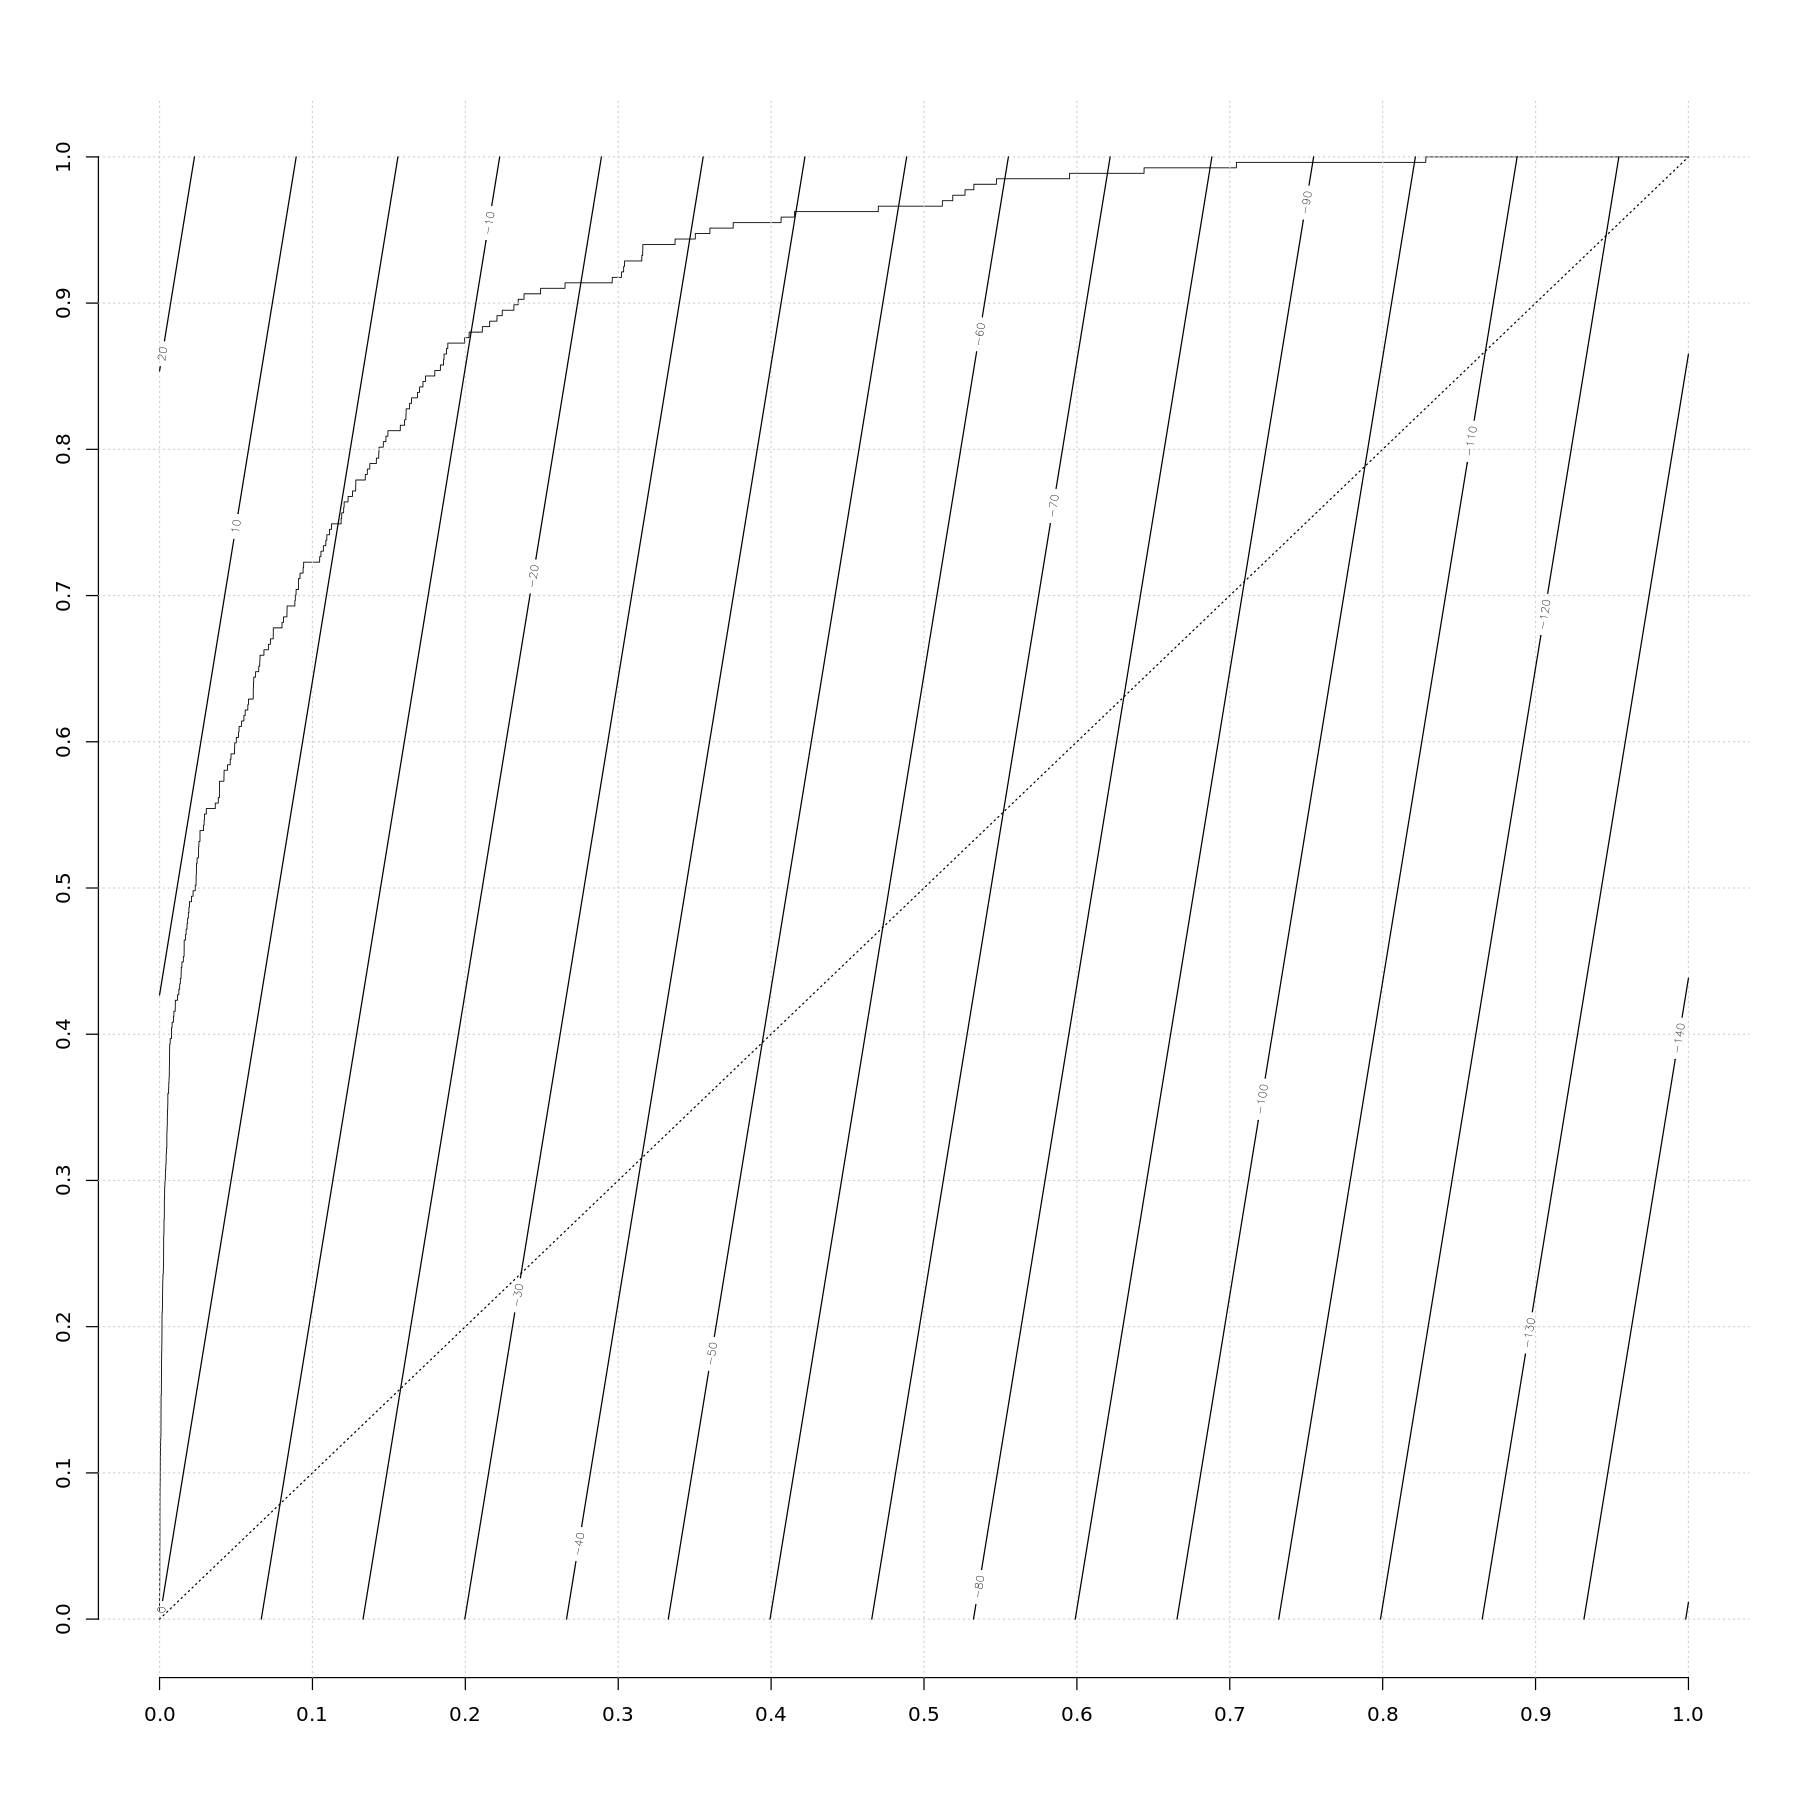

In [11]:
#ROC con curvas de nivel de ganancia
pred <- prediction(test$score, test[,..kobjetivo])
perf <- performance(pred, measure = "tpr", x.measure = "fpr")

performance( pred,"auc")@y.values

tot_positivos = sum( test[,..kobjetivo] )
tot_negativos = nrow(test) - sum( test[,..kobjetivo] )

options(repr.plot.width=15, repr.plot.height=15)

plot.new()  
plot(perf,
       add = TRUE,
       lwd=.7,
       main="ROC Curves",
       avg = "vertical")
  grid(col="lightgray")
  axis(1, at=seq(0, 1, by=0.1))
  axis(2, at=seq(0, 1, by=0.1))
  abline(v=c(0.1, 0.3, 0.5, 0.7, 0.9), col="lightgray", lty="dotted")
  abline(h=c(0.1, 0.3, 0.5, 0.7, 0.9), col="lightgray", lty="dotted")
  lines(x=c(0, 1), y=c(0, 1), col="black", lty="dotted")

par( new=TRUE)
x <- seq(0, 1, len = 1500)
y <- seq(0, 1, len = 1500)

r <- outer(tot_negativos*x*problema$ganancia_FP *3/1000000,tot_positivos*y*(problema$ganancia_TP )*3/1000000,"+")

contour(r, axes = FALSE, nlevels = 15)

In [12]:
t0       <-  Sys.time()
modelo  <- ranger( data = dataset,  
                   formula_obj,  
                   probability=TRUE,
                   num.trees= 900, 
                   min.node.size= 360, 
                   mtry= 4, 
                   splitrule='gini'
                 ) 
t1       <-  Sys.time()

tcorrida <-  as.numeric( t1 - t0, units = "secs")
print( tcorrida)


Growing trees.. Progress: 34%. Estimated remaining time: 1 minute, 0 seconds.
Growing trees.. Progress: 69%. Estimated remaining time: 28 seconds.
[1] 99.61726


In [13]:
#Leo datos a estimar
dataset_pred <- fread(karchivo_predecir)

#Armo dataset de salida
dataset_salida <- dataset_pred[,..kcampo_id]
setnames(dataset_salida, c("Id") )

#Transformo los datos de la misma forma que el dataset de entrenamiento
dataset_pred[,(kobjetivo) := as.integer(0)]
dataset_pred[ ,  (kcampos_a_borrar) := NULL    ] 
dataset_pred[is.na(dataset_pred)] <- 0

In [14]:
#Calculo el score
predicted <- predict(modelo, dataset_pred)
dataset_pred$score <- predicted$predictions[,2]

In [15]:
#Selecciono los que estan por encima del umbral
dataset_pred$Predicted <- dataset_pred$score > problema$prob_corte 

#Grabo salida
dataset_salida[,"Predicted"] <- dataset_pred$Predicted
write.csv(dataset_salida,"./salida_ranger.csv", row.names = FALSE)